In [1]:
ENV["PYTHON"] = "/home/jair/anaconda3/envs/py36/bin/python"
using Pkg
Pkg.build("PyCall");

  Building Conda ─→ `~/.julia/packages/Conda/CpuvI/deps/build.log`
  Building PyCall → `~/.julia/packages/PyCall/0jMpb/deps/build.log`


In [2]:
using DataFrames
using CSV
using PyCall
using PyPlot
using StatsBase

using ScikitLearn
@pyimport sklearn.datasets as datasets
@pyimport sklearn.naive_bayes as NB
@pyimport sklearn.tree as Tree
@pyimport sklearn.linear_model as LM
@pyimport sklearn.ensemble as E
@pyimport sklearn.svm as SVM

@pyimport sklearn.metrics as METRICS

@pyimport nltk.stem as NLTK_STEM
@pyimport nltk.corpus as NLTK_CORPUS

In [3]:
#===========================
    Load files
===========================#

path = "/home/jair/Desktop/FACTMATA/"
fileTrain = "trainA.csv"
fileTest = "testA.csv"

dfTrain = CSV.read( string(path, fileTrain))
names!(dfTrain, [:ID,:Tweet, :Target, :Stance, :OpinionsTowards, :Sentiment])
dfTest = CSV.read(string(path, fileTest))
names!(dfTest, [:ID1,:ID2, :Target,:Tweet, :Stance])
dfTest[:Sentiment] = map(i -> i, 1:size(dfTest, 1))
dfTest[:OpinionsTowards] = map(i -> i, 1:size(dfTest, 1));

In [121]:
#===========================
    NLP from scratch
============================#

stopWords = NLTK_CORPUS.stopwords[:words]("english")
filterWords = vcat([""], stopWords)

stemmer = NLTK_STEM.SnowballStemmer("english")

function largestSentenceOnly(corpus)
    maxCorpus = maximum(map(c -> length(c), corpus))
    for c in corpus
        if length(c) == maxCorpus
            return c
        end
    end
end

function parseTxt2BoW(text)
    # 1. decompose into sentences
    # 2. sentences -> Nag of Words
    
    function lowerCase(wrd)
       try
            lowercase(wrd) |> 
                (W -> filter(s -> !(s in ['\"']), W)) |>  # , '-', '+', '~'
                stemmer[:stem]
        catch # found strange characters in dataset, maybe emoticons? '\x90','\xa2','\xb4','\xa0','\xb4','\xd3'
            wrd
        end
    end
    
    function massageText(wrds)
        # filter words
        wrds = filter(w -> !(w in filterWords), wrds)
        # filter words with symbols
        filter(w -> true, wrds) |> # !(w[1] in ['#', '@']), wrds)
            (W -> map(w -> lowerCase(w), W))
    end
    
    
    split(text, ['.','!','?']) |> 
        (txt -> map(t -> (split(t, [' ',',','/','\'',';',':',]) |> massageText), 
                    txt)) |> #largestSentenceOnly |>
        (T -> vcat(T...)) |>
        (T -> filter(x -> x != "", T))
end


#===
    Test parser on real tweets
===#

for (i,t) in enumerate(vcat(dfTrain[:Tweet])
    try
        parseTxt2BoW(t)
    catch
        println("bug in train: ", i)
    end
end

for (i,t) in enumerate(dfTest[:Tweet])
    try
        parseTxt2BoW(t)
    catch
        println("bug in test: ", i)
    end
end

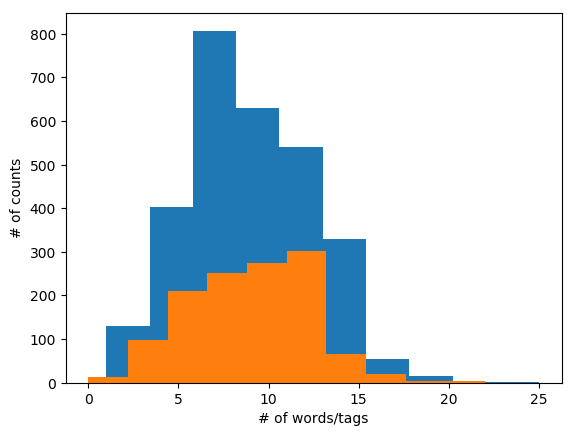

In [66]:
#===
    Used to fined tuned the SDR model
===#

lengthsTrain = map(t -> length(vcat(parseTxt2BoW(t)...)), dfTrain[:Tweet])  
lengthsTest = map(t -> length(vcat(parseTxt2BoW(t)...)), dfTest[:Tweet])
using PyPlot
xlabel("# of words/tags")
ylabel("# of counts")
hist(lengthsTrain)
hist(lengthsTest);

In [117]:
#=====================
    SDRs model 0.1
======================#

using SparseArrays

function RandomIndexGenerator(n, w)
    # generates random vector of form [0 0 0 ... 0 1 0 ... 0 0 0 0 0 0 1 0 0 0 0 ...]
    ...
end

# std cosine sim
function standardCosineSimilarity(v1, v2)
    v2' * v2 / ((v1' * v1) * (v2' * v2))^.5
end

function sparseCosineSimilarity(ri1, ri2)

    sparseVectorMultiplication(ri1, ri2) = 
        ...

    sparseVectorMultiplication(ri1, ri2) / 
        (length(ri2.nzval) * length(ri2.nzval))^.5
    end


#================
# Data Model 0.1
=================#

# length of sdrs
n = 10000

# cardinals (for text and tag)
# numbers are tweaked so vectors remain sparse after composition
wTxt, wTag, wTarget = 1, 1, 13 # 5, 10, 5

# "encoding model"
fields = [:Tweet, :Target]
dicWeights = Dict(:Tweet => wTxt, :Target => wTarget)

# Map data into random vector via simple compositions/additions
function dataRow2SDR(dfRow)
    idces = []
    target = dfRow[:Target]
    ...
    
    txtBoW = vcat(parseTxt2BoW(dfRow[:Tweet])...)
    
    biGrams = [string("_BI_", string(sort([txtBoW[i],txtBoW[i-1]]))) for i=2:length(txtBoW)]
    
    biGramsSkip1 = [string("_BI_SKIP1_", string(sort([txtBoW[i],txtBoW[i-2]]))) for i=3:length(txtBoW)]
    
    triGrams = [string("_TRI_", string(sort([txtBoW[i],txtBoW[i-1], txtBoW[2-1]]))) for i=3:length(txtBoW)]
    
    for wrd in txtBoW # vcat(txtBoW,  biGrams, biGramsSkip1, triGrams) 
        ...
    end
    
    ...
    sparsevec(idces, 1:length(idces))
end

# We build SDRs dictionary "as you go"
dicSDRs = Dict()

function encodeOnTheFly(wrdOrTag, dictSDRs, w)
    if haskey(dictSDRs, wrdOrTag)
        dictSDRs[wrdOrTag].nzind
    else
        randSDR = RandomIndexGenerator(n, w)
        dictSDRs[wrdOrTag] = randSDR
        randSDR.nzind
    end
end

function sparse2Dense(sparseVec)
    v = zeros(n)
    for i in sparseVec.nzind
         v[i] = 1
    end
    v
end


function getF1Scores(yTest, yClassified)
    #===
        fmacroT and fmicroT for "main classes"
    ===#    
    f1Macro = METRICS.f1_score(yTest, yClassified, average="macro")
    f1Micro = METRICS.f1_score(yTest, yClassified, average="micro")
    
    idcesFavor = filter(i -> yTest[i] == classes["FAVOR"], 1:length(yTest)) 
    idcesAgainst = filter(i -> yTest[i] == classes["AGAINST"], 1:length(yTest))
    idcesNone = filter(i -> yTest[i] == classes["NONE"], 1:length(yTest))
    
    fFavorMacro = METRICS.f1_score(map(i -> yTest[i], idcesFavor), 
                                   map(i -> yClassified[i], idcesFavor), average="macro")
    fAgainstMacro = METRICS.f1_score(map(i -> yTest[i], idcesAgainst),
                                     map(i -> yClassified[i], idcesAgainst), average="macro")
    fNoneMacro = METRICS.f1_score(map(i -> yTest[i], idcesNone),
                                  map(i -> yClassified[i], idcesNone), average="macro")
    
    fFavorMicro = METRICS.f1_score(map(i -> yTest[i], idcesFavor),
                                   map(i -> yClassified[i], idcesFavor), average="micro")
    fAgainstMicro = METRICS.f1_score(map(i -> yTest[i], idcesAgainst),
                                     map(i -> yClassified[i], idcesAgainst), average="micro")
    fNoneMicro = METRICS.f1_score(map(i -> yTest[i], idcesNone),
                                  map(i -> yClassified[i], idcesNone), average="micro")

    Dict(:fMacro => (fFavorMacro + fAgainstMacro) / 2,
         :fMicro => (fFavorMicro + fAgainstMicro) / 2,
         :fMacroT => (fFavorMacro + fAgainstMacro + fNoneMacro) / 3,
         :fMicroT => (fFavorMicro + fAgainstMicro + fNoneMicro) / 3)
end;

In [123]:
#==================================
    Test SDRs + choose best model
==================================#


classes = unique(map(w -> w, dfTrain[:Stance]))
classes = Dict([classes[i] => i-1 for i = 1:length(classes)])
dic = StatsBase.countmap(map(w -> w, dfTrain[:Stance]))

#===
my_clf = E.RandomForestClassifier(n_estimators=500) LM.LogisticRegression() E.RandomForestClassifier()
my_clf[:set_params](class_weight=Dict([classes[d[1]] => size(dfTrain[:Stance], 1) / d[2]
                                      for d in collect(dic)]))
===#

my_clf = NB.BernoulliNB()


dicTestSDR = Dict()
scoresF1, scores, f1Micro, f1Macro = [], [], [], []
for i=1:25
    
    dicSDRs = Dict()
    
    println(i)
    #=== VALIDATION Tests
    randIdces = rand(1:size(dfTrain, 1), size(dfTrain, 1))
    dataRandIdces = map(i -> dfTrain[i, 1:end], randIdces)

    yTrain = map(c -> classes[c[:Stance]], dataRandIdces[1:end-500])
    xTrain = map(d -> dataRow2SDR(d), dataRandIdces[1:end-500])
    yTest = map(c -> classes[c[:Stance]], dataRandIdces[end-500:end])
    xTest = map(d -> dataRow2SDR(d), dataRandIdces[end-500:end]);
    ===#
    #===#
    yTrain = map(c -> classes[c], dfTrain[:Stance])
    xTrain = [dataRow2SDR(dfTrain[i, 1:end]) for i =1:size(dfTrain, 1)]
    yTest = map(c -> classes[c], dfTest[:Stance])
    xTest = [dataRow2SDR(dfTest[i, 1:end]) for i =1:size(dfTest, 1)]
    #===#
    vv = map(x -> sparse2Dense(x), xTrain) #map(i -> sparse2Dense(xTrain[i]), 1:size(xTrain)[1])
    println("avg lgth: ", sum(map(v -> sum(v), vv)) / length(vv))
    my_clf[:fit](vv, yTrain) 
    vv = map(i -> sparse2Dense(xTest[i]), 1:size(xTest)[1])
    y = my_clf[:predict](vv)
    score = sum(map(i -> y[i] == yTest[i], 1:length(y))) / length(y)
    append!(scores, score)
    println(score)
    f1 = METRICS.f1_score(yTest, y, average="macro")
    append!(scoresF1, f1)
    println(f1)
    f1Dict = getF1Scores(yTest, y)
    println(f1Dict)
    append!(f1Micro, f1Dict[:fMicro])
    append!(f1Macro, f1Dict[:fMacro])
    dicTestSDR[i] = dicSDRs
end


println("scores: ", sum(scores) / length(scores))
println("f1: ", sum(scoresF1) / length(scoresF1))
println("Macro: ", sum(f1Macro) / length(scores))
println("Micro: ", sum(f1Micro) / length(scoresF1))

1
avg lgth: 24.221002059025395
0.6477181745396317
0.44469372435474125
Dict(:fMacro=>0.346506,:fMicro=>0.69649,:fMicroT=>0.471573,:fMacroT=>0.235732)
2
avg lgth: 24.215168153740564
0.6461168935148118
0.4431005292659438
Dict(:fMacro=>0.345807,:fMicro=>0.694146,:fMicroT=>0.47001,:fMacroT=>0.235266)
3
avg lgth: 24.216540837336993
0.644515612489992
0.4415539867519896
Dict(:fMacro=>0.344779,:fMicro=>0.690856,:fMicroT=>0.467817,:fMacroT=>0.234581)
4
avg lgth: 24.223747426218257
0.6461168935148118
0.4398833290824214
Dict(:fMacro=>0.266763,:fMicro=>0.697435,:fMicroT=>0.469305,:fMacroT=>0.180703)
5
avg lgth: 24.22031571722718
0.6405124099279423
0.4381801643999546
Dict(:fMacro=>0.2633,:fMicro=>0.685469,:fMicroT=>0.464226,:fMacroT=>0.180261)
6
avg lgth: 24.21551132463967
0.6541232986389112
0.4518347441189745
Dict(:fMacro=>0.348141,:fMicro=>0.70233,:fMicroT=>0.476916,:fMacroT=>0.237744)
7
avg lgth: 24.22168840082361
0.6461168935148118
0.4444031670058702
Dict(:fMacro=>0.346764,:fMicro=>0.696982,:fMi

/home/jair/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jair/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jair/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jair/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jair/anaconda3/envs/py36/lib/python3.6/sit

avg lgth: 24.21551132463967
0.6461168935148118
0.4444740847725226
Dict(:fMacro=>0.400901,:fMicro=>0.697927,:fMicroT=>0.472531,:fMacroT=>0.271996)
19
avg lgth: 24.217913520933426
0.6501200960768615
0.4466398456897544
Dict(:fMacro=>0.347071,:fMicro=>0.698588,:fMicroT=>0.472971,:fMacroT=>0.236109)
20
avg lgth: 24.212079615648594
0.6477181745396317
0.44843304236746867
Dict(:fMacro=>0.267017,:fMicro=>0.697681,:fMicroT=>0.473816,:fMacroT=>0.183661)
21
avg lgth: 24.040150995195606
0.6525220176140912
0.4430965092055758
Dict(:fMacro=>0.269401,:fMicro=>0.707511,:fMicroT=>0.474572,:fMacroT=>0.181516)
22
avg lgth: 24.221345229924502
0.6453162530024019
0.4378874691440549
Dict(:fMacro=>0.26587,:fMicro=>0.694845,:fMicroT=>0.467578,:fMacroT=>0.180108)
23
avg lgth: 24.01372683596431
0.6405124099279423
0.43855707232753255
Dict(:fMacro=>0.264084,:fMicro=>0.68736,:fMicroT=>0.465486,:fMacroT=>0.180784)
24
avg lgth: 24.218943033630747
0.6405124099279423
0.43036840187246184
Dict(:fMacro=>0.264072,:fMicro=>0.

###    BEST SCORE AND SDR MODEL


#### MY BEST SCORE for A (with a very simple model):

#### precision: = 0.6565252201761409
#### F1: 0.4553448542112077
#### F-microT and F-macroT as specified in : "A dataset for detecting stances in Tweets" (Mohammad, Kirichenko, ...)
#### fMicro=>0.707264
#### fMacro=>0.349652

#### Dict(:fMacro=>0.349652,:fMicro=>0.707264,:fMicroT=>0.480205,:fMacroT=>0.238751)